Requirements:

pip install lpips

pip install torchmetrics

In [3]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from torchvision import transforms
from os import listdir
from os.path import isfile, join
import glob
import os
import PIL.Image
import six.moves.queue as Queue
import threading
import os
import sys
import glob
import argparse
import threading
import six.moves.queue as Queue
import traceback
import numpy as np
import tensorflow as tf
import torch
from PIL import Image
import torchvision.transforms as transforms
import lpips
import pandas as pd
from torchmetrics import StructuralSimilarityIndexMeasure
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
my_lpips = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth


In [5]:
ssim = StructuralSimilarityIndexMeasure()

In [7]:
def compute_similarity(folder_path):
    df = pd.DataFrame(columns=['age','gender','ethnicity','LPIPS'])
    import scipy.ndimage
    inpainted_folder_path = os.path.join(folder_path,'inpainted')
    gt_folder_path = os.path.join(folder_path,'gt')
    list_images = [f for f in listdir(gt_folder_path) if isfile(join(gt_folder_path, f))]
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    for i,image_name in enumerate(list_images):
        gt_img = PIL.Image.open(os.path.join(gt_folder_path, image_name))
        gt_img_tensor = transform(gt_img)
        gt_img_array = np.asarray(gt_img)
        inpainted_img = PIL.Image.open(os.path.join(inpainted_folder_path, image_name))
        inpainted_img_tensor = transform(inpainted_img)
        inpainted_img_array = np.asarray(inpainted_img)
        df_new = pd.DataFrame({'age':[image_name[9:11]],
                             'gender':[image_name[12]],
                             'ethnicity':[image_name[14]],
                             'LPIPS':[float(my_lpips(gt_img_tensor,inpainted_img_tensor))],
                             'SSIM':[float(ssim(inpainted_img_tensor.float().unsqueeze(0),gt_img_tensor.float().unsqueeze(0)))]},
                             index=[i])
        df = df.append(df_new)
    return df

In [8]:
folder_path = 'inpainting_results'
df_similarity = compute_similarity(folder_path)

In [26]:
df_similarity['age_category'] = df_similarity['age'].apply(lambda n:0 if int(n)<30 else 1 if int(n)<60 else 2)

## Effect of belonging to several minorities on the inpainting quality

Regression on binary variables

In [35]:
mean_old_indian = df_similarity[(df_similarity['age_category']==2)&(df_similarity['ethnicity']=='3')]['SSIM'].mean()
mean_old_non_indian = df_similarity[(df_similarity['age_category']==2)&(df_similarity['ethnicity']!='3')]['SSIM'].mean()
mean_non_old_indian = df_similarity[(df_similarity['age_category']!=2)&(df_similarity['ethnicity']=='3')]['SSIM'].mean()
mean_non_old_non_indian = df_similarity[(df_similarity['age_category']!=2)&(df_similarity['ethnicity']!='3')]['SSIM'].mean()
print(f'The estimation of delta is {mean_old_indian-mean_old_non_indian-mean_non_old_indian+mean_non_old_non_indian}')

In [40]:
mean_old_indian-mean_old_non_indian-mean_non_old_indian+mean_non_old_non_indian

-0.014328027727586456

# Regressions using the mean

In [9]:
df_similarity_gender = df_similarity.groupby('gender').agg('mean')

df_similarity_ethnicity = df_similarity.groupby('ethnicity').agg('mean')

df_similarity_age = df_similarity
df_similarity_age['age_category'] = df_similarity_age['age'].apply(lambda n:0 if int(n)<30 else 1 if int(n)<60 else 2)
df_similarity_age = df_similarity_age.groupby('age_category').agg('mean')

Linear regression on the age category

In [10]:
X_age = np.array([[44.7],[55.3],[0.]])
Y_age = df_similarity_age['LPIPS'].values

reg = LinearRegression().fit(X_age, Y_age)
Y_pred = reg.predict(X_age)

Coefficients: 
 [-0.00030359]
Mean squared error: 0.00
Coefficient of determination: 0.81


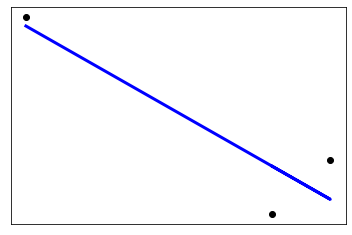

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_age, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_age, Y_pred))

plt.scatter(X_age,Y_age,color='black')
plt.plot(X_age,Y_pred,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Linear regression of LPIPS on the ethnicity

In [12]:
X_ethnicity = np.array([[72.9],[4.6],[6.3],[0.9]])
Y_ethnicity = df_similarity_ethnicity['LPIPS'].values

reg_ethnicity = LinearRegression().fit(X_ethnicity, Y_ethnicity)
Y_pred_ethnicity = reg_ethnicity.predict(X_ethnicity)

Coefficients: 
 [-0.00017117]
Mean squared error: 0.00
Coefficient of determination: 0.44


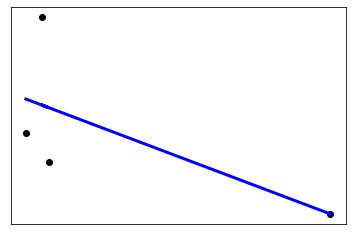

In [13]:
print("Coefficients: \n", reg_ethnicity.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_ethnicity, Y_pred_ethnicity))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_ethnicity, Y_pred_ethnicity))

plt.scatter(X_ethnicity,Y_ethnicity,color='black')
plt.plot(X_ethnicity,Y_pred_ethnicity,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Linear regression of LPIPS on gender

In [ ]:
X_gender = np.array([[11057/30000],[18943/30000]])
Y_gender = df_similarity_gender['LPIPS'].values

reg_gender = LinearRegression().fit(X_gender, Y_gender)
Y_pred_gender = reg_gender.predict(X_gender)

Coefficients: 
 [-0.00641285]
Mean squared error: 0.00
Coefficient of determination: 1.00


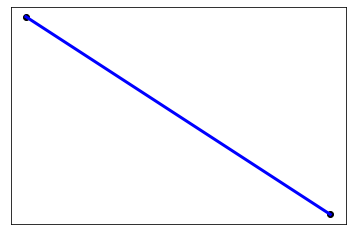

In [ ]:
print("Coefficients: \n", reg_gender.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_gender, Y_pred_gender))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_gender, Y_pred_gender))

plt.scatter(X_gender,Y_gender,color='black')
plt.plot(X_gender,Y_pred_gender,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Linear regression of SSIM on the age category

In [ ]:
X_age = np.array([[44.7],[55.3],[0.]])
Y_age = df_similarity_age['SSIM'].values

reg = LinearRegression().fit(X_age, Y_age)
Y_pred = reg.predict(X_age)

Coefficients: 
 [0.00073752]
Mean squared error: 0.00
Coefficient of determination: 0.87


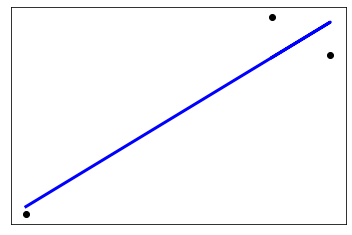

In [ ]:
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_age, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_age, Y_pred))

plt.scatter(X_age,Y_age,color='black')
plt.plot(X_age,Y_pred,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Linear regression of SSIM on the ethnicity

Coefficients: 
 [0.00020138]
Mean squared error: 0.00
Coefficient of determination: 0.43


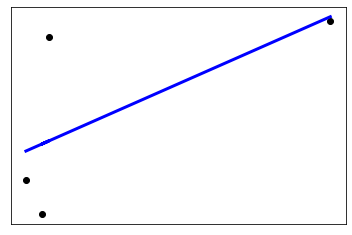

In [ ]:
X_ethnicity = np.array([[72.9],[4.6],[6.3],[0.9]])
Y_ethnicity = df_similarity_ethnicity['SSIM'].values

reg_ethnicity = LinearRegression().fit(X_ethnicity, Y_ethnicity)
Y_pred_ethnicity = reg_ethnicity.predict(X_ethnicity)

print("Coefficients: \n", reg_ethnicity.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_ethnicity, Y_pred_ethnicity))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_ethnicity, Y_pred_ethnicity))

plt.scatter(X_ethnicity,Y_ethnicity,color='black')
plt.plot(X_ethnicity,Y_pred_ethnicity,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Linear regression of SSIM on gender

Coefficients: 
 [0.02002991]
Mean squared error: 0.00
Coefficient of determination: 1.00


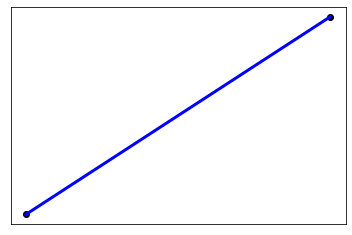

In [ ]:
X_gender = np.array([[11057/30000],[18943/30000]])
Y_gender = df_similarity_gender['SSIM'].values

reg_gender = LinearRegression().fit(X_gender, Y_gender)
Y_pred_gender = reg_gender.predict(X_gender)

print("Coefficients: \n", reg_gender.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_gender, Y_pred_gender))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_gender, Y_pred_gender))

plt.scatter(X_gender,Y_gender,color='black')
plt.plot(X_gender,Y_pred_gender,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

# Regressions using the median

In [42]:
df_similarity_gender = df_similarity.groupby('gender').agg('median')

df_similarity_ethnicity = df_similarity.groupby('ethnicity').agg('median')

df_similarity_age = df_similarity
df_similarity_age['age_category'] = df_similarity_age['age'].apply(lambda n:0 if int(n)<30 else 1 if int(n)<60 else 2)
df_similarity_age = df_similarity_age.groupby('age_category').agg('median')

Coefficients: 
 [-0.00026552]
Mean squared error: 0.00
Coefficient of determination: 0.76


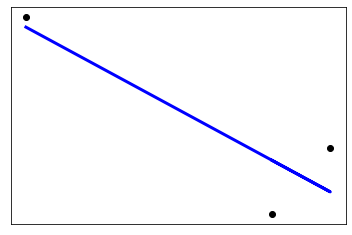

In [43]:
X_age = np.array([[44.7],[55.3],[0.]])
Y_age = df_similarity_age['LPIPS'].values

reg = LinearRegression().fit(X_age, Y_age)
Y_pred = reg.predict(X_age)

print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_age, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_age, Y_pred))

plt.scatter(X_age,Y_age,color='black')
plt.plot(X_age,Y_pred,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Coefficients: 
 [-0.00015167]
Mean squared error: 0.00
Coefficient of determination: 0.39


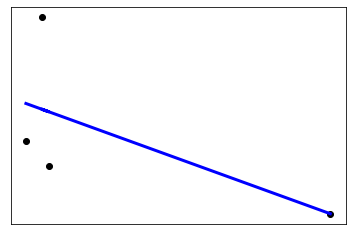

In [44]:
X_ethnicity = np.array([[72.9],[4.6],[6.3],[0.9]])
Y_ethnicity = df_similarity_ethnicity['LPIPS'].values

reg_ethnicity = LinearRegression().fit(X_ethnicity, Y_ethnicity)
Y_pred_ethnicity = reg_ethnicity.predict(X_ethnicity)

print("Coefficients: \n", reg_ethnicity.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_ethnicity, Y_pred_ethnicity))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_ethnicity, Y_pred_ethnicity))

plt.scatter(X_ethnicity,Y_ethnicity,color='black')
plt.plot(X_ethnicity,Y_pred_ethnicity,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Coefficients: 
 [-0.00183394]
Mean squared error: 0.00
Coefficient of determination: 1.00


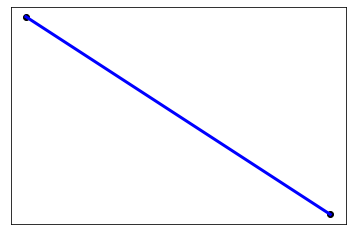

In [45]:
X_gender = np.array([[11057/30000],[18943/30000]])
Y_gender = df_similarity_gender['LPIPS'].values

reg_gender = LinearRegression().fit(X_gender, Y_gender)
Y_pred_gender = reg_gender.predict(X_gender)

print("Coefficients: \n", reg_gender.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_gender, Y_pred_gender))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_gender, Y_pred_gender))

plt.scatter(X_gender,Y_gender,color='black')
plt.plot(X_gender,Y_pred_gender,color='blue',linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

Coefficients: 
 [0.00071892]
Mean squared error: 0.00
Coefficient of determination: 0.89


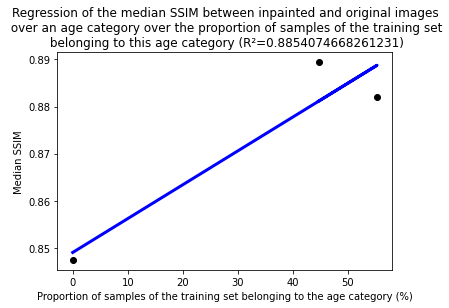

In [55]:
X_age = np.array([[44.7],[55.3],[0.]])
Y_age = df_similarity_age['SSIM'].values

reg = LinearRegression().fit(X_age, Y_age)
Y_pred = reg.predict(X_age)

print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_age, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_age, Y_pred))

plt.scatter(X_age,Y_age,color='black')
plt.plot(X_age,Y_pred,color='blue',linewidth=3)

plt.xlabel("Proportion of samples of the training set belonging to the age category (%)")
plt.ylabel("Median SSIM")
plt.title(f"Regression of the median SSIM between inpainted and original images\n over an age category over the proportion of samples of the training set\n belonging to this age category (R²={r2_score(Y_age, Y_pred)})")

plt.show()

Coefficients: 
 [0.00016211]
Mean squared error: 0.00
Coefficient of determination: 0.55


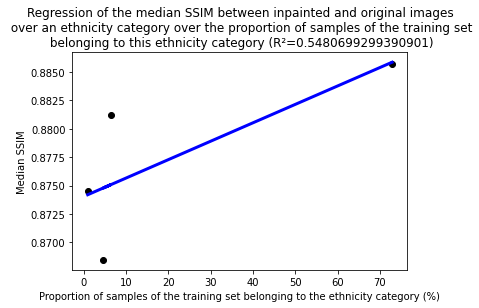

In [54]:
X_ethnicity = np.array([[72.9],[4.6],[6.3],[0.9]])
Y_ethnicity = df_similarity_ethnicity['SSIM'].values

reg_ethnicity = LinearRegression().fit(X_ethnicity, Y_ethnicity)
Y_pred_ethnicity = reg_ethnicity.predict(X_ethnicity)

print("Coefficients: \n", reg_ethnicity.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_ethnicity, Y_pred_ethnicity))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_ethnicity, Y_pred_ethnicity))

plt.scatter(X_ethnicity,Y_ethnicity,color='black')
plt.plot(X_ethnicity,Y_pred_ethnicity,color='blue',linewidth=3)

plt.xlabel("Proportion of samples of the training set belonging to the ethnicity category (%)")
plt.ylabel("Median SSIM")
plt.title(f"Regression of the median SSIM between inpainted and original images\n over an ethnicity category over the proportion of samples of the training set\n belonging to this ethnicity category (R²={r2_score(Y_ethnicity, Y_pred_ethnicity)})")


plt.show()

Coefficients: 
 [0.02993002]
Mean squared error: 0.00
Coefficient of determination: 1.00


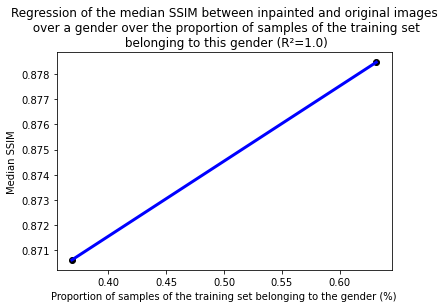

In [56]:
X_gender = np.array([[11057/30000],[18943/30000]])
Y_gender = df_similarity_gender['SSIM'].values

reg_gender = LinearRegression().fit(X_gender, Y_gender)
Y_pred_gender = reg_gender.predict(X_gender)

print("Coefficients: \n", reg_gender.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_gender, Y_pred_gender))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_gender, Y_pred_gender))

plt.scatter(X_gender,Y_gender,color='black')
plt.plot(X_gender,Y_pred_gender,color='blue',linewidth=3)

plt.xlabel("Proportion of samples of the training set belonging to the gender (%)")
plt.ylabel("Median SSIM")
plt.title(f"Regression of the median SSIM between inpainted and original images\n over a gender over the proportion of samples of the training set\n belonging to this gender (R²={r2_score(Y_gender, Y_pred_gender)})")


plt.show()